In [1]:
import warnings
warnings.filterwarnings( 'ignore' )

import os
import random
import numpy as np
import pandas as pd
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import torch
from transformers import get_linear_schedule_with_warmup
from lightning_fabric import Fabric


from utils.config import Parameters
from utils.dataset import Dataset
from utils.performance_evaluation import performance_evaluation
from utils.utils import format_time
from utils.logger import init_logger 
from utils.early_stopping import EarlyStopping
from utils.Classifier import Classifier

In [2]:
seed = 42

np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
# When running on the CuDNN backend, two further options must be set
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
# Set a fixed value for the hash seed
os.environ["PYTHONHASHSEED"] = str(seed)
torch.set_float32_matmul_precision('medium')


# Setup Fabric
fabric = Fabric(accelerator="auto", devices="auto", precision="bf16-mixed", strategy="auto")
fabric.launch()

Using bfloat16 Automatic Mixed Precision (AMP)


### Parameters

In [3]:
# Get parameters
args = Parameters()

# Project directory
if (not os.path.exists(args.output_dir)):
    os.mkdir(args.output_dir)

# Create logger
logger = init_logger(log_file = 'logs.log') 

### Data

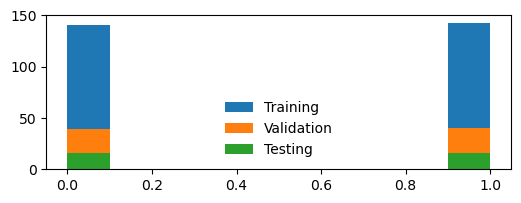

In [4]:
df = pd.read_csv(args.dataset_path, sep='&')
df['label'] = df['label'].astype('float')
# Split Train/Test datasets
df_train, df_test = train_test_split(df, test_size=args.test_size, shuffle=True, stratify=df['label'])
# Create validation dataset
df_train, df_valid = train_test_split(df_train, test_size=args.valid_size, shuffle=True, stratify=df_train['label'])

# Reset indices
df_train = df_train.reset_index().drop(['index'], axis=1)
df_valid = df_valid.reset_index().drop(['index'], axis=1) 
df_test = df_test.reset_index().drop(['index'], axis=1)

# Class Visualization
plt.figure(figsize = (6,2))
plt.hist(df_train['label']);
plt.hist(df_test['label']);
plt.hist(df_valid['label']);

plt.legend(['Training', 'Validation', 'Testing'], frameon=False);

#### Data loaders

In [5]:
# Create dataset
train_dataset = Dataset(df_train)
# Create data loader
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=args.train_batch_size, shuffle=True)


# Create dataset
valid_dataset = Dataset(df_valid)
# Create data loader
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=args.train_batch_size, shuffle=False)


# Create dataset
test_dataset = Dataset(df_test)
# Create data loader
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=args.test_batch_size, shuffle=False)

logger.info('Dataloader were created')

[INFO] Dataloader were created


### Model

In [6]:
from utils.Classifier import Classifier

model = Classifier(args=args).to(args.device);

[INFO] Load pretrained SentenceTransformer: lighteternal/stsb-xlm-r-greek-transfer


#### Training parameters

In [7]:
param_optimizer = list(model.named_parameters())
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]


optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": args.weight_decay,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]

# Setup optimizer
if args.optimizer == 'AdamW':
    optimizer = torch.optim.AdamW(optimizer_parameters, lr=args.learning_rate)
elif args.optimizer == 'RMSprop':
    optimizer = torch.optim.RMSprop(optimizer_parameters, lr=args.learning_rate)  
elif args.optimizer == 'Adam':
    optimizer = torch.optim.Adam(optimizer_parameters, lr=args.learning_rate)
elif args.optimizer == 'SGD':
    optimizer = torch.optim.SGD(optimizer_parameters, lr=args.learning_rate, momentum=args.momentum)
    
# Setup scheduler
num_train_steps = int(train_loader.__len__() / args.train_batch_size * args.epochs)
scheduler = get_linear_schedule_with_warmup(optimizer=optimizer, 
                                            num_warmup_steps=0, 
                                            num_training_steps=num_train_steps)
# from utils.scheduler import LRScheduler
# scheduler = LRScheduler(optimizer = optimizer, 
#                         patience  = 10, 
#                         min_lr    = 1e-8, 
#                         factor    = 0.5, 
#                         verbose   = True)

# Early stopping
early_stopping = EarlyStopping(patience  = 20,
                               min_delta = 0)

logger.info('Training parameters were setup')

[INFO] Training parameters were setup


In [8]:
# Convert model, loaders & optimizer to fabric setup
model, optimizer = fabric.setup(model, optimizer)

train_loader = fabric.setup_dataloaders(train_loader)
valid_loader = fabric.setup_dataloaders(valid_loader)
test_loader = fabric.setup_dataloaders(test_loader)

#### Training process

In [9]:
best_AUC = 0
history = {'train_loss': [], 'valid_loss': [], 
           'train_accuracy': [], 'valid_accuracy': [], 
           'train_AUC': [], 'valid_AUC': []}


for epoch in range(args.epochs):

    t0 = time.time()

    # Activate training mode
    model.train()
    
    # setup loop with TQDM and dataloader
    loop = tqdm(train_loader, leave=True)
    # setup epoch's metrics
    metrics = {'losses': [], 'accuracy': [], 'AUC': []}
    # initialize calculated gradients (from prev step)
    optimizer.zero_grad()
    for step, batch in enumerate(loop):
        # pull all tensor batches required for training
        text = batch['text']
        labels = batch['labels'].to(args.device)
        # Get loss and predictions
        loss, predictions = model(text=text, labels=labels)      
        # Calculate performance metrics
        accuracy, AUC, _ = performance_evaluation(labels, predictions)
        # extract loss - normalized
        loss = loss / args.number_accumulated_gradients      
        # Backpropagate errors  
        fabric.backward(loss)

        if (step+1) % args.number_accumulated_gradients == 0 or (step+1) % len(train_loader) == 0: 
            # update parameters
            optimizer.step()
            # Update scheduler
            scheduler.step()
            # Reset gradients tensors
            optimizer.zero_grad()

        # Add loss/accuracy/AUC
        metrics['losses'].append(loss.item())
        metrics['accuracy'].append(accuracy)
        metrics['AUC'].append(AUC)


        # add stuff to progress bar in the end
        loop.set_description(f"Epoch [{epoch+1}/{args.epochs}]")
        loop.set_postfix(loss=np.mean(metrics['losses']), accuracy=f"{np.mean(metrics['accuracy']):.2f}%", AUC=np.mean(metrics['AUC']))

    # Calculate test loss/accuracy/AUC
    train_loss = np.mean(metrics['losses'])
    train_accuracy = np.mean(metrics['accuracy'])
    train_AUC= np.mean(metrics['AUC'])


    
    model.eval()
    # setup loop with TQDM and dataloader
    loop = tqdm(valid_loader, leave=True)
    # setup epoch's metrics
    metrics = {'losses': [], 'accuracy': [], 'AUC': [], 'CM': None}
    for step, batch in enumerate(loop):

        # pull all tensor batches required for training
        text = batch['text']
        labels = batch['labels'].to(args.device)
        # Get loss & predictions
        loss, predictions = model(text=text, labels=labels)
        
        # Calculate performance metrics
        accuracy, AUC, CM = performance_evaluation(labels, predictions)
        # Add loss/accuracy/AUC
        metrics['losses'].append(loss.item())
        metrics['accuracy'].append(accuracy)
        metrics['AUC'].append(AUC)
        if metrics['CM'] is None: metrics['CM'] = CM 
        else: metrics['CM'] += CM

        loop.set_description("Validation")    
        loop.set_postfix(loss=np.mean(metrics['losses']), accuracy=f"{np.mean(metrics['accuracy']):.2f}%", AUC=np.mean(metrics['AUC']))

    # Calculate test loss/accuracy/AUC
    valid_loss = np.mean(metrics['losses'])
    valid_accuracy = np.mean(metrics['accuracy'])
    valid_AUC= np.mean(metrics['AUC'])
    # Elapsed time per epoch
    elapsed = format_time(time.time() - t0)


    # Store performance
    history['train_loss'].append(train_loss)    
    history['valid_loss'].append(valid_loss)
    history['train_accuracy'].append(train_accuracy)    
    history['valid_accuracy'].append(valid_accuracy)
    history['train_AUC'].append(train_AUC)    
    history['valid_AUC'].append(valid_AUC) 

    
    # Update best model
    if valid_AUC > best_AUC:
        torch.save(model, os.path.join(args.output_dir, "model.pt"))
        torch.save(model.state_dict(), os.path.join(args.output_dir, "pytorch_model.bin"))
        best_AUC = valid_AUC    
        
    # # Learning rate scheduler
    # scheduler(valid_loss)

    # Early Stopping
    if early_stopping(valid_loss): break    

Epoch [4/50]:  28%|██▊       | 20/71 [00:00<00:01, 31.62it/s, AUC=0.488, accuracy=58.33%, loss=0.679]

#### Training performance

In [ ]:
df_results = pd.DataFrame.from_dict(history)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 3))
df_results[['train_accuracy','valid_accuracy']].plot(ax=ax[0], marker='o')
df_results[['train_loss','valid_loss']].plot(ax=ax[1], marker='o')
ax[0].legend(frameon=False, fontsize=12);
ax[1].legend(frameon=False, fontsize=12);

#### Evaluation of Testing set

In [ ]:
# Load optimized model
model = torch.load(f"{args.output_dir}/model.pt")
model.eval();

print('[INFO] Model loaded')

In [ ]:
with torch.no_grad():

    # setup loop with TQDM and dataloader
    loop = tqdm(test_loader, leave=True)
    # setup epoch's metrics
    metrics = {'losses': [], 'accuracy': [], 'AUC': [], 'CM': 0}
    for step, batch in enumerate(loop):
        # pull all tensor batches required for training
        text = batch['text']
        labels = batch['labels'].to(args.device)
        # Get loss & predictions
        loss, predictions = model(text=text, labels=labels)
        # Calculate performance metrics
        accuracy, AUC, CM = performance_evaluation(labels, predictions)
        
        # Add loss/accuracy/AUC
        metrics['losses'].append(loss.item())
        metrics['accuracy'].append(accuracy)
        metrics['AUC'].append(AUC)
        if metrics['CM'] is None: metrics['CM'] = CM 
        else: metrics['CM'] += CM
        
        loop.set_description("Validation")    
        loop.set_postfix(loss=np.mean(metrics['losses']), accuracy=f"{np.mean(metrics['accuracy']):.2f}%", AUC=np.mean(metrics['AUC']))

In [ ]:
print(f"Loss: {np.mean(metrics['losses']):.3f}")
print(f"Accuracy: {np.mean(metrics['accuracy']):.2f}%")
print(f"AUC: {np.mean(metrics['AUC']):.3f}")
print(metrics['CM'])

In [ ]:
# import json

# # Serialize JSON by converting all objects to strings
# d = vars(args).copy()
# d = {x:str(d[x]) for x in d.keys()}

# # Store parameters
# with open(args.output_dir + '/parameters.json', 'w') as fp:
#     json.dump(d, fp)